Here are used custom functions and classes, their code is found on Custom_Class_Func.py

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [100]:
data = pd.read_csv('weatherAUS.csv')

In [101]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [104]:
data['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [105]:
data['RainTomorrow'].isna().value_counts()

False    142193
True       3267
Name: RainTomorrow, dtype: int64

Dataset is imbalanced and there are several missing values both in the X features and between the target values. We will evaluate the model in the following different dataset configurations:
- Without the examples relative to the target missing values, with the X missing values handled (imputed) by xgboost;
- With all the missing values imputed by kNN Imputer from sklearn.

We will also handle the imbalance by:
- Stratifying;
- Ensembling the resampled dataset.

Since the presence of the imbalance, we will show also AUC scores along with others.

In [106]:
missing = data.isna().sum().sort_values()
missing_ratio = data.isna().sum()/data.isna().count()
missing_matrix = pd.concat([missing, missing_ratio], axis=1)

In [107]:
#Drop the features with more than one third of data missing

drop_indexes = missing_matrix[missing_matrix[1] > 0.33].index

In [108]:
processed_data = data.drop(drop_indexes, axis=1)

In [109]:
#Select only data with target values not missing
X_y = processed_data[processed_data['RainTomorrow'].isna() == False]

Testing with chi squared and anova to see if some features can be discarded

In [110]:
cat = X_y[['Location','WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']]

In [111]:
from sklearn.feature_selection import chi2, f_classif

In [112]:
cat.dropna(inplace=True)

C:\Users\clzin\miniconda3\envs\DSA\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
cat = cat.apply(LabelEncoder().fit_transform)

In [114]:
chi_scores = chi2(cat.drop(['RainTomorrow'], axis=1), cat['RainTomorrow'])

In [115]:
cont = data.drop(['Location','WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow'], axis=1)
cont['RainTomorrow'] = cat['RainTomorrow']

In [116]:
cont.dropna(inplace=True)
cont.drop('Date', axis=1, inplace=True)

In [117]:
anova_scores = f_classif(cont.drop(['RainTomorrow'], axis=1), cont['RainTomorrow'])

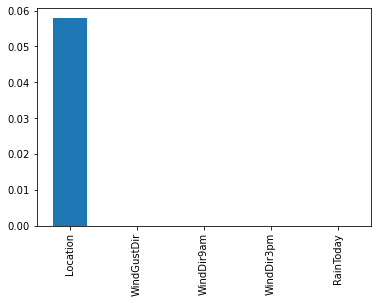

In [118]:
p_values = pd.Series(chi_scores[1],index = cat.columns[0:-1])
p_values.plot.bar();

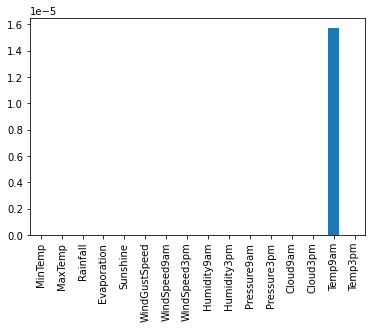

In [119]:
f_p_values = pd.Series(anova_scores[1],index = cont.columns[0:-1])
f_p_values.plot.bar();

The test's p-values indicate that location must be discarded since its presence it's not statistically significant if we choose alpha = 0.05. Despite of this, location can be important since in certain areas some conditions could give rain while in other not. Furthermore alpha can be choosen higher since Type I errors do not lead to dramatic effects in this case (e.g. counting location when it's not needed). For the sake of curiosity, for once, we will produce also the results relative to not taking location into account. 

In [120]:
# Encoding and leaving NaN values

from Custom_Class_Func import MultiColumnLabelEncoder

In [121]:
# we will mask to keep NaN's and replace after encoding
original = X_y
mask = X_y.isnull()

In [122]:
X_y = MultiColumnLabelEncoder(columns=['Location','WindGustDir','WindDir9am',
                                'WindDir3pm','RainToday','RainTomorrow']).fit_transform(X_y.astype(str))

In [123]:
X_y = X_y.where(~mask, original).drop(['Date'],axis=1)

In [124]:
X_y.isna().values.any()  #checking if masking was successful

True

In [125]:
X_y = X_y.astype(float)
X = X_y.drop('RainTomorrow', axis=1)
y = X_y['RainTomorrow']

# No Imputing

## Stratifying

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y )

In [128]:
import xgboost as xgb

In [129]:
# we will use n_jobs to parallelize computation among different threads 
# (in my pc max 12, but empiric evidence shows best with 10)
# we also will use early stopping to avoid overfitting

model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, n_estimators = 10000, n_jobs=10)
model.fit(X_train, y_train, verbose=False,
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

XGBClassifier(n_estimators=10000, n_jobs=10, use_label_encoder=False)

[[0.73858618 0.03724437]
 [0.10385665 0.12031281]] 

Area under ROC curve: 0.74434946476334
Precision: 0.7636136404213534
Recall: 0.5367047308319739


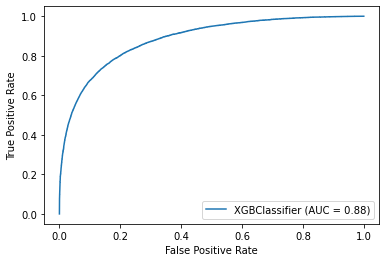

In [133]:
y_pred = model.predict(X_test)

results = pd.Series({'AUC_ROC' : roc_auc_score(y_test, y_pred), 
                     'Precision' : precision_score(y_test, y_pred),
                     'Recall' : recall_score(y_test, y_pred)},
                      name='No_imput_Stratify')
                                
print(confusion_matrix(y_test, y_pred)/y_pred.shape, '\n')
print('Area under ROC curve:', results['AUC_ROC'])
print('Precision:',results['Precision'])
print('Recall:', results['Recall'])
plot_roc_curve(model, X_test, y_test);

### Fine Tuning

In [132]:
tpr

array([nan, nan, nan])

In [33]:
from sklearn.model_selection import GridSearchCV 

In [34]:
#fine tuning, taking imbalance in account
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [3, 5, 44] # as XGBoost recommends: sum(negative instances) / sum(positive instances)
}


In [35]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', n_estimators = 10000,
                               subsample=0.9, colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=False,
    n_jobs = 10,
    cv = 3)

In [36]:
optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10,                
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


In [40]:
# run again tuning with borderline params from before
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.05],
    'gamma': [0.25],
    'reg_lambda': [10.0],
    'scale_pos_weight': [2,3] 
}


In [41]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', n_estimators = 10000,
                               subsample=0.9, colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=False,
    n_jobs = 10,
    cv = 3)

In [42]:
optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10,                
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 2}


In [41]:
# The previous params are confirmed
model = xgb.XGBClassifier(objective='binary:logistic', gamma=0.25, learn_rate=0.05,
                        max_depth=5, reg_lambda=10, scale_pos_weight=2, n_estimators=10000, n_jobs=10)
model.fit(X_train, y_train, verbose=False,
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

XGBClassifier(gamma=0.25, learn_rate=0.05, max_depth=5, n_estimators=10000,
              n_jobs=10, reg_lambda=10, scale_pos_weight=2)

In [42]:
y_pred = model.predict(X_test)

a = {'AUC_ROC' : roc_auc_score(y_test, y_pred), 'Precision' : precision_score(y_test, y_pred),
        'Recall' : recall_score(y_test, y_pred)}

results = pd.concat([results, pd.Series(a, name='No_imput_Stratify_optimized')], axis=1)

[[0.6951813  0.08064924]
 [0.07271653 0.15145292]] 

Area under Roc curve: 0.7858329402977511
Precision: 0.6525269664283118
Recall: 0.675618019826829


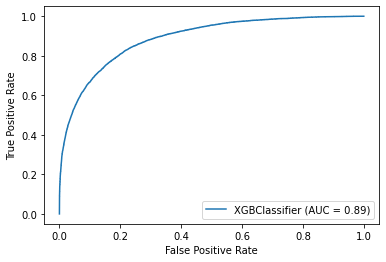

In [44]:
print(confusion_matrix(y_test, y_pred)/y_pred.shape, '\n')
print('Area under Roc curve:', a['AUC_ROC'])
print('Precision:',a['Precision'])
print('Recall:', a['Recall'])
plot_roc_curve(model, X_test, y_test);

## Ensembled resampling
We will use **custom functions** to compute predictions.

In [46]:
from Custom_Class_Func import get_resampled_datasets, get_xgboost_ensemble_predictions, ensemble_xgboost_CV

In [47]:
a = ensemble_xgboost_CV(X_y, threads=10)

[[0.58629299 0.18953513]
 [0.05963851 0.16453337]]
Area under Roc curve: 0.7448301859292419
Precision: 0.46469361406296555
Recall: 0.7339607843137255


[[0.56769112 0.208137  ]
 [0.05999015 0.16418173]]
Area under Roc curve: 0.7320574753402243
Precision: 0.440970910464677
Recall: 0.7323921568627451


[[0.62349673 0.15233139]
 [0.0665307  0.15764118]]
Area under Roc curve: 0.7534344306366884
Precision: 0.5085649461145775
Recall: 0.7032156862745098


[[0.56378789 0.21204023]
 [0.05000352 0.17416837]]
Area under Roc curve: 0.7518164614166385
Precision: 0.4509696804151871
Recall: 0.7769411764705882


[[0.67705074 0.09873071]
 [0.08185366 0.1423649 ]]
Area under Roc curve: 0.7538359618839595
Precision: 0.5904914685722619
Recall: 0.6349380586482672


Average scores: 

Area under Roc curve: 0.7471949030413505
Precision: 0.4911381239259338
Recall: 0.7162895725139672


In [48]:
results = pd.concat([results, pd.Series(a, name='No_imput_Ensembled')], axis=1)

# kNN Imputer
## Stratifying

In [45]:
# pick the dataset with missing values in target values
X_y = processed_data

In [46]:
original = X_y
mask = X_y.isnull()
X_y = MultiColumnLabelEncoder(columns=['Location','WindGustDir','WindDir9am',
                                'WindDir3pm','RainToday','RainTomorrow']).fit_transform(X_y.astype(str))
X_y = X_y.where(~mask, original).drop(['Date'],axis=1)
X_y = X_y.astype(float)

In [47]:
from sklearn.impute import KNNImputer

In [49]:
imputer = KNNImputer(n_neighbors=4)
imputed_dataset = imputer.fit_transform(X_y)

In [50]:
columns = X_y.columns

In [51]:
X_y = pd.DataFrame(imputed_dataset, columns=columns)

In [52]:
X = X_y.drop('RainTomorrow', axis=1)
y = X_y['RainTomorrow']

# Because imputer sometimes gives values between 1 and 0 and the majority of y values are 0:
y = y.apply(lambda x: 0 if x <= 0.5 else 1)  

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y )

In [54]:
model_1 = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, n_estimators = 10000, n_jobs=10)
model_1.fit(X_train, y_train, verbose=False,
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

XGBClassifier(n_estimators=10000, n_jobs=10, use_label_encoder=False)

In [57]:
y_pred = model_1.predict(X_test)
a = {'AUC_ROC' : roc_auc_score(y_test, y_pred), 'Precision' : precision_score(y_test, y_pred),
        'Recall' : recall_score(y_test, y_pred)}

results = pd.concat([results, pd.Series(a, name='kNNImput_Stratify')], axis=1)

[[0.74164719 0.03695861]
 [0.10699849 0.11439571]]
Area under Roc curve: 0.7346191577117154
Precision: 0.7558139534883721
Recall: 0.5167059992547509


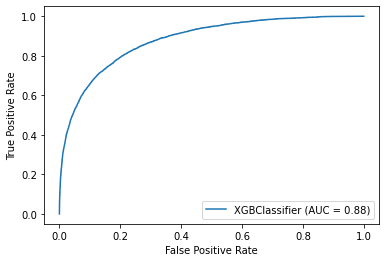

In [58]:
print(confusion_matrix(y_test, y_pred)/y_pred.shape)
print('Area under Roc curve:', roc_auc_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
plot_roc_curve(model_1, X_test, y_test);

### Fine Tuning

In [62]:
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [1.0, 10.0],
    'scale_pos_weight': [2, 3] # as XGBoost recommends: sum(negative instances) / sum(positive instances)
}

In [63]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', n_estimators = 10000,
                               subsample=0.9, colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=False,
    n_jobs = 10,
    cv = 3)

In [64]:
optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10,                
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 2}


In [ ]:
# The previous params are confirmed
model_1 = xgb.XGBClassifier(objective='binary:logistic', gamma=0.25, learn_rate=0.05,
                        max_depth=5, reg_lambda=10, scale_pos_weight=2, n_estimators=10000, n_jobs=10)
model_1.fit(X_train, y_train, verbose=False,
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

In [72]:
y_pred = model.predict(X_test)
a = {'AUC_ROC' : roc_auc_score(y_test, y_pred), 'Precision' : precision_score(y_test, y_pred),
        'Recall' : recall_score(y_test, y_pred)}

results = pd.concat([results, pd.Series(a, name='kNNImput_Stratify_optimized')], axis=1)

In [ ]:
print(confusion_matrix(y_test, y_pred)/y_pred.shape)
print('Area under Roc curve:', roc_auc_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
plot_roc_curve(model, X_test, y_test);

## Ensambled Resampling

In [74]:
a = ensemble_xgboost_CV(X_y, threads=10)

[[0.61753959 0.15994432]
 [0.06427701 0.15823908]]
Area under Roc curve: 0.7527075075712808
Precision: 0.497320354369463
Recall: 0.7111354394745073


[[0.56686967 0.21061423]
 [0.05554202 0.16697407]]
Area under Roc curve: 0.7397494548659622
Precision: 0.4422119815668203
Recall: 0.7503909915545824


[[0.61625196 0.16123195]
 [0.06420741 0.15830868]]
Area under Roc curve: 0.7520358302483485
Precision: 0.49542583315181876
Recall: 0.7114482327181733


[[0.5683313  0.2091526 ]
 [0.04691143 0.17560466]]
Area under Roc curve: 0.7600826118024433
Precision: 0.4564037626628075
Recall: 0.7891773537691585


[[0.67200223 0.10547011]
 [0.07714524 0.14538242]]
Area under Roc curve: 0.758832604061974
Precision: 0.5795533361076433
Recall: 0.653322908522283


Average scores: 

Area under Roc curve: 0.7526816017100018
Precision: 0.49418305357171055
Recall: 0.723094985207741


In [75]:
results = pd.concat([results, pd.Series(a, name='kNNImput_Ensembled')], axis=1)

# Confrontation

In [78]:
results

,No_imput_Stratify,No_imput_Stratify_optimized,No_imput_Ensembled,kNNImput_Stratify,kNNImput_Stratify_optimized,kNNImput_Ensembled
AUC_ROC,0.745272,0.790064,0.747195,0.740462,0.800768,0.752682
Precision,0.764109,0.661304,0.491138,0.752245,0.668485,0.494183
Recall,0.538587,0.680888,0.716290,0.530617,0.700286,0.723095


# Final Considerations 
Stratifying per se yelds worse perfomance in terms of area under the ROC curve than ensembled resampling, while, through parameter optimization, it gives the best results overall.\
Leaving the missing values handling to xgboost makes no particular difference with imputing them with kNN. The latter performs slightly better, but the fact that some values have been imputed by an algorithm could be easily exploited by xgboost since imputation does not come from chance.\
Generally speaking, Ensembled samples, as a way to fight imbalance, give good results but are more prone to enhance recall rater than precision.